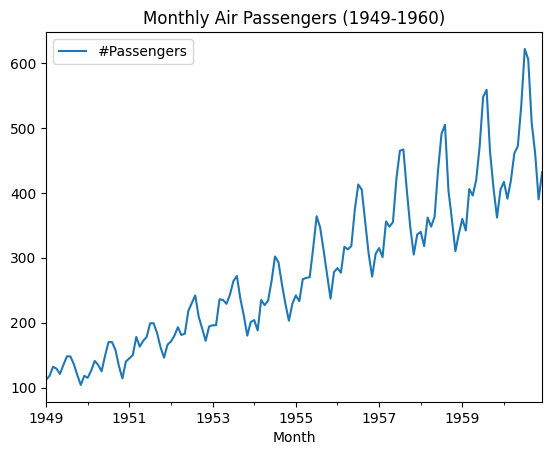

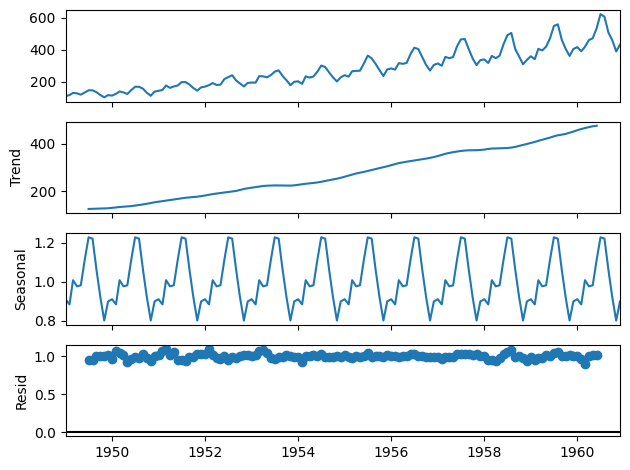

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load dat
df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
df.plot(title='Monthly Air Passengers (1949-1960)')
plt.show()

# Decompose into trend, seasonality, and residuals
decomposition = seasonal_decompose(df, model='multiplicative')
decomposition.plot()
plt.show()

2. Train-Test Split

Training: First 80% (1949-1958)
Test: Last 20% (1959-1960)

In [6]:
train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]


3. Forecasting Models



A. Simple Models

Naive Forecast (Last Observation Carried Forward)

In [9]:
naive_forecast = test.shift(1)

Simple Average

In [10]:
avg_forecast = pd.Series(np.mean(train), index=test.index)

Moving Average (12-month)



In [11]:
ma_forecast = train.rolling(12).mean().iloc[-1]

B. Exponential Smoothing

Simple Exponential Smoothing (SES)

In [12]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
ses_model = SimpleExpSmoothing(train).fit()
ses_forecast = ses_model.forecast(len(test))

/home/bengali/Documents/GitHub/AirPassengers_Forecasting.ipynb/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Holt’s Linear Trend

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
holt_model = ExponentialSmoothing(train, trend='add').fit()
holt_forecast = holt_model.forecast(len(test))

/home/bengali/Documents/GitHub/AirPassengers_Forecasting.ipynb/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Holt-Winters (Multiplicative Seasonality)

In [14]:
hw_model = ExponentialSmoothing(train, seasonal='mul', trend='add', seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(len(test))

/home/bengali/Documents/GitHub/AirPassengers_Forecasting.ipynb/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


C. ARIMA & SARIMA

ARIMA (Manual p,d,q Selection)



In [ ]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train, order=(5,1,0)).fit()
arima_forecast = arima_model.forecast(len(test))

# Replace Auto-ARIMA with manual ARIMA selection


/home/bengali/Documents/GitHub/AirPassengers_Forecasting.ipynb/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/bengali/Documents/GitHub/AirPassengers_Forecasting.ipynb/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/bengali/Documents/GitHub/AirPassengers_Forecasting.ipynb/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Try different (p,d,q) combinations manually
arima_model = ARIMA(train, order=(2,1,2)).fit()
arima_forecast = arima_model.forecast(len(test))

Auto-ARIMA (Automated Selection)

In [ ]:
from pmdarima import auto_arima
auto_model = auto_arima(train, seasonal=True, m=12)
auto_forecast = auto_model.predict(len(test))


In [ ]:
from sktime.forecasting.arima import AutoARIMA

# Convert DateTimeIndex to PeriodIndex (monthly)
train = train.to_period('M')  # 'M' for month-end, 'MS' for month-start

forecaster = AutoARIMA(
    seasonal=True,
    sp=12,  # seasonal period (12 for monthly data)
    suppress_warnings=True
)
forecaster.fit(train)

# Predict next N steps (same length as test set)
auto_forecast = forecaster.predict(fh=list(range(1, len(test)+1)))

In [16]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(seasonal=True, sp=12)
forecaster.fit(train)

# Simple integer-based prediction
auto_forecast = forecaster.predict(fh=len(test))  # predict next N periods

ModuleNotFoundError: AutoARIMA requires package 'pmdarima' to be present in the python environment, but 'pmdarima' was not found. 'pmdarima' is a dependency of AutoARIMA and required to construct it. To install the requirement 'pmdarima', please run: `pip install pmdarima` 

In [15]:
# Explicitly set frequency if missing
train = train.asfreq('MS')  # 'MS' for month-start, 'M' for month-end

forecaster = AutoARIMA(seasonal=True, sp=12)
forecaster.fit(train)

# Use relative forecasting horizon
auto_forecast = forecaster.predict(fh=list(range(1, len(test)+1)))

ValueError: MS is not supported as period frequency

SARIMA (Seasonal ARIMA)

In [36]:
sarima_model = ARIMA(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
sarima_forecast = sarima_model.forecast(len(test))

D. LSTM (Deep Learning)

In [ ]:


from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)

# Prepare LSTM input (window=12)
X, y = [], []
for i in range(12, len(scaled_train)):
    X.append(scaled_train[i-12:i])
    y.append(scaled_train[i])
X, y = np.array(X), np.array(y)

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=1)

# Forecast
inputs = df[len(df)-len(test)-12:].values
inputs = scaler.transform(inputs)
X_test = []
for i in range(12, len(inputs)):
    X_test.append(inputs[i-12:i])
X_test = np.array(X_test)
lstm_forecast = model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

In [48]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))

# Prepare sequences (window=12)
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return torch.FloatTensor(X), torch.FloatTensor(y)

X, y = create_sequences(scaled_train, window=12)

# Define LSTM model
class LSTMForecaster(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

model = LSTMForecaster()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train
for epoch in range(20):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

# Predict (similar to your original code)
test_seq = torch.FloatTensor(scaled_train[-12:].reshape(1, 12, 1))
preds = []
for _ in range(len(test)):
    with torch.no_grad():
        pred = model(test_seq)
    preds.append(pred.item())
    test_seq = torch.cat((test_seq[:, 1:, :], pred.reshape(1, 1, 1)), dim=1)

lstm_forecast = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

C:\Users\Sajid\AppData\Local\Temp\ipykernel_22248\2576353935.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.FloatTensor(X), torch.FloatTensor(y)


E. Regression-Based Forecasting

Linear Trend Model



In [39]:
from sklearn.linear_model import LinearRegression
X = np.arange(len(train)).reshape(-1, 1)
y = train.values
model = LinearRegression().fit(X, y)
X_test = np.arange(len(train), len(train)+len(test)).reshape(-1, 1)
linear_forecast = model.predict(X_test)

Exponential Trend Model

In [40]:
log_y = np.log(y)
exp_model = LinearRegression().fit(X, log_y)
exp_forecast = np.exp(exp_model.predict(X_test))

4. Model Evaluation (RMSE, MAE, MAPE)

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(forecast, actual):
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return rmse, mae, mape

models = {
    "Naive": naive_forecast,
    "Average": avg_forecast,
    "Moving Avg (12)": ma_forecast,
    "SES": ses_forecast,
    "Holt's": holt_forecast,
    "Holt-Winters": hw_forecast,
    "ARIMA": arima_forecast,
    "Auto-ARIMA": auto_forecast,
    "SARIMA": sarima_forecast,
    "LSTM": lstm_forecast,
    "Linear Trend": linear_forecast,
    "Exponential Trend": exp_forecast
}

results = []
for name, forecast in models.items():
    rmse, mae, mape = evaluate(forecast, test)
    results.append([name, rmse, mae, mape])

results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "MAPE"])
print(results_df.sort_values("RMSE"))

ValueError: Input contains NaN.

In [61]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(forecast, actual, handle_nan='remove'):
    """
    Evaluate forecast performance with NaN handling options

    Parameters:
    - forecast: array-like, predicted values
    - actual: array-like, true values
    - handle_nan: str, how to handle NaN values ('remove', 'fill_mean', 'fill_zero')

    Returns:
    - rmse, mae, mape: evaluation metrics
    """
    # Convert forecast to 1D numpy array
    if isinstance(forecast, pd.DataFrame):
        forecast = forecast.iloc[:, 0].values
    elif isinstance(forecast, pd.Series):
        forecast = forecast.values
    elif isinstance(forecast, np.ndarray):
        forecast = forecast.flatten()
    else:
        forecast = np.asarray(forecast)

    # Convert actual to 1D numpy array
    if isinstance(actual, pd.DataFrame):
        actual = actual.iloc[:, 0].values
    elif isinstance(actual, pd.Series):
        actual = actual.values
    elif isinstance(actual, np.ndarray):
        actual = actual.flatten()
    else:
        actual = np.asarray(actual)

    # Align lengths if needed (take min length)
    min_len = min(len(forecast), len(actual))
    forecast = forecast[:min_len]
    actual = actual[:min_len]

    # Handle NaN values
    if np.isnan(forecast).any():
        if handle_nan == 'remove':
            mask = ~np.isnan(forecast)
            forecast = forecast[mask]
            actual = actual[mask]
        elif handle_nan == 'fill_mean':
            forecast = np.nan_to_num(forecast, nan=np.nanmean(forecast))
        elif handle_nan == 'fill_zero':
            forecast = np.nan_to_num(forecast, nan=0)
        else:
            raise ValueError("handle_nan must be 'remove', 'fill_mean', or 'fill_zero'")

    if len(forecast) == 0:
        return np.nan, np.nan, np.nan

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((actual - forecast) / actual)) * 100

    return rmse, mae, mape

def compare_models(models, test_data, handle_nan='remove'):
    """
    Compare multiple forecasting models
    
    Parameters:
    - models: dict of {model_name: forecast_values}
    - test_data: array-like, true values
    - handle_nan: str, how to handle NaN values
    
    Returns:
    - DataFrame with evaluation metrics sorted by RMSE
    """
    results = []
    for name, forecast in models.items():
        try:
            rmse, mae, mape = evaluate(forecast, test_data, handle_nan)
            results.append({
                "Model": name,
                "RMSE": rmse,
                "MAE": mae,
                "MAPE": mape,
                "Has_NaN": np.isnan(forecast).any()
            })
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            results.append({
                "Model": name,
                "RMSE": np.nan,
                "MAE": np.nan,
                "MAPE": np.nan,
                "Has_NaN": np.isnan(forecast).any()
            })
    
    results_df = pd.DataFrame(results)
    return results_df.sort_values("RMSE")

# Example usage:
models = {
    "Naive": naive_forecast,
    "Average": avg_forecast,
    "Moving Avg (12)": ma_forecast,
    "SES": ses_forecast,
    "Holt's": holt_forecast,
    "Holt-Winters": hw_forecast,
    "ARIMA": arima_forecast,
    "Auto-ARIMA": auto_forecast,
    "SARIMA": sarima_forecast,
    "LSTM": lstm_forecast,
    "Linear Trend": linear_forecast,
    "Exponential Trend": exp_forecast
}

# Compare models (choose one NaN handling method)
results_df = compare_models(models, test, handle_nan='remove')  # or 'fill_mean' or 'fill_zero'
print(results_df)

# Show which models had NaN values
print("\nModels with NaN values:")
print(results_df[results_df['Has_NaN']]['Model'].tolist())

                Model        RMSE         MAE       MAPE  \
5        Holt-Winters   26.047636   21.966456   4.819640   
8              SARIMA   30.138915   23.552465   5.052027   
0               Naive   53.354944   45.821429  10.531124   
10       Linear Trend   73.804902   55.989481  12.071380   
6               ARIMA   82.513011   63.545311  14.216159   
11  Exponential Trend   85.911562   76.687371  18.587891   
3                 SES   92.980867   81.302516  20.158854   
7          Auto-ARIMA   97.629635   97.629635  19.332601   
4              Holt's  127.125405  113.585516  28.548674   
2     Moving Avg (12)  128.666667  128.666667  25.478548   
9                LSTM  160.269048  139.037254  29.434597   
1             Average  215.057269  200.362519  43.852483   

                             Has_NaN  
5                              False  
8                              False  
0    #Passengers    True
dtype: bool  
10                             False  
6                       

TypeError: unhashable type: 'Series'

1. Metric Comparison Bar Plot


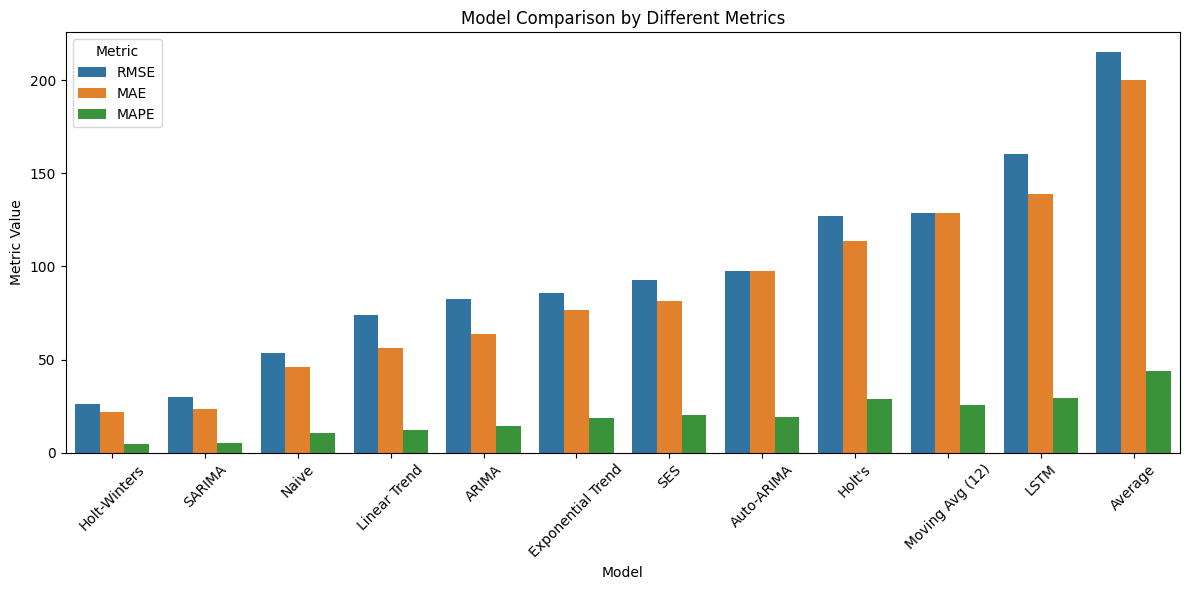

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the dataframe for easier plotting
plot_df = results_df.melt(id_vars="Model", value_vars=["RMSE", "MAE", "MAPE"], 
                         var_name="Metric", value_name="Value")

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="Model", y="Value", hue="Metric")
plt.title("Model Comparison by Different Metrics")
plt.xticks(rotation=45)
plt.ylabel("Metric Value")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

2. Actual vs Forecast Plot (Top 3 Models)

C:\Users\Sajid\AppData\Local\Temp\ipykernel_22248\3950129247.py:5: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(models[model], label=f'{model} Forecast', alpha=0.7, linestyle='--')


ConversionError: Failed to convert value(s) to axis units: array([Period('1958-08', 'M'), Period('1958-09', 'M'),
       Period('1958-10', 'M'), Period('1958-11', 'M'),
       Period('1958-12', 'M'), Period('1959-01', 'M'),
       Period('1959-02', 'M'), Period('1959-03', 'M'),
       Period('1959-04', 'M'), Period('1959-05', 'M'),
       Period('1959-06', 'M'), Period('1959-07', 'M'),
       Period('1959-08', 'M'), Period('1959-09', 'M'),
       Period('1959-10', 'M'), Period('1959-11', 'M'),
       Period('1959-12', 'M'), Period('1960-01', 'M'),
       Period('1960-02', 'M'), Period('1960-03', 'M'),
       Period('1960-04', 'M'), Period('1960-05', 'M'),
       Period('1960-06', 'M'), Period('1960-07', 'M'),
       Period('1960-08', 'M'), Period('1960-09', 'M'),
       Period('1960-10', 'M'), Period('1960-11', 'M'),
       Period('1960-12', 'M')], dtype=object)

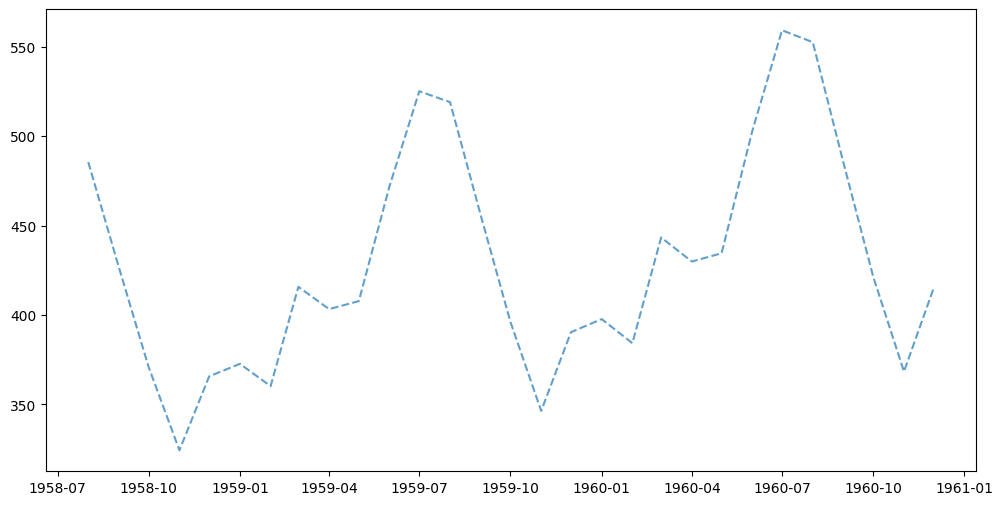

In [65]:
top_models = results_df['Model'].head(3)

plt.figure(figsize=(12, 6))
for model in top_models:
    plt.plot(models[model], label=f'{model} Forecast', alpha=0.7, linestyle='--')
    
plt.plot(test.values, label='Actual', linewidth=2)
plt.title("Top Models: Forecast vs Actual")
plt.xlabel("Time Period")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3. Metric Radar Chart

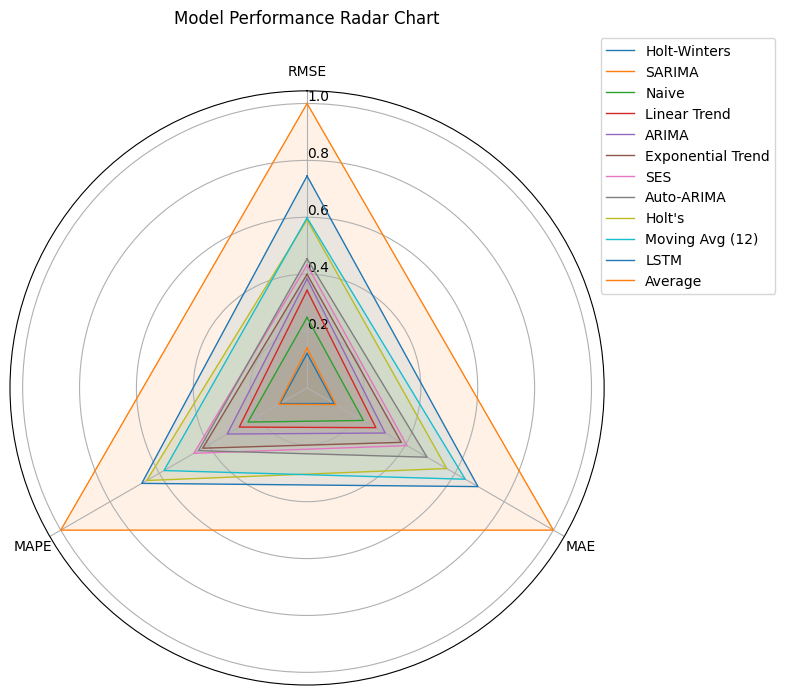

In [66]:
from math import pi

# Normalize metrics for radar chart
radar_df = results_df.copy()
for col in ['RMSE', 'MAE', 'MAPE']:
    radar_df[col] = radar_df[col] / radar_df[col].max()

categories = list(radar_df.columns[1:4])
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories)
ax.set_rlabel_position(0)

for idx, row in radar_df.iterrows():
    values = row[['RMSE', 'MAE', 'MAPE']].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=row['Model'])
    ax.fill(angles, values, alpha=0.1)

plt.title("Model Performance Radar Chart", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

4. Ranking Heatmap

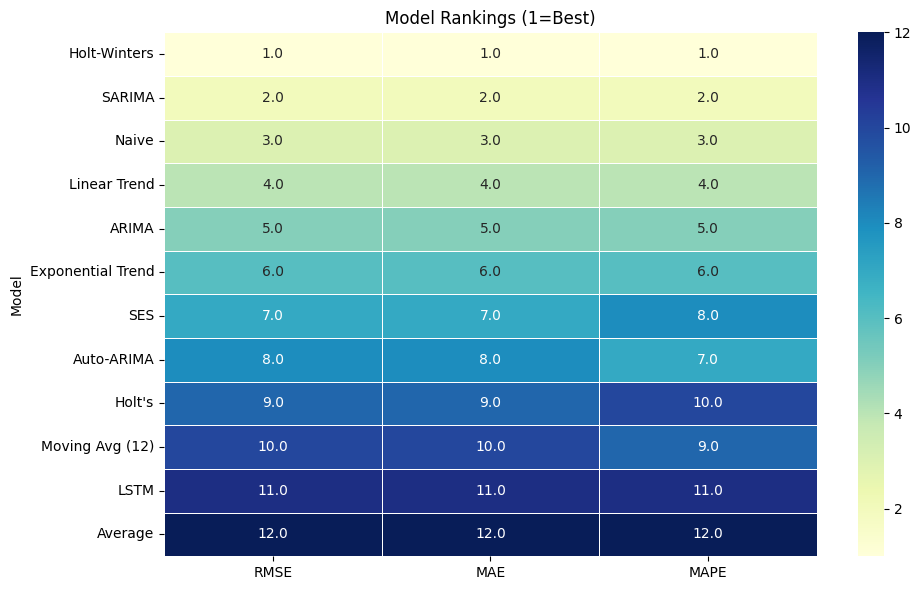

In [67]:
# Create ranking for each metric
rank_df = results_df.copy()
for col in ['RMSE', 'MAE', 'MAPE']:
    rank_df[col] = rank_df[col].rank(ascending=True)

plt.figure(figsize=(10, 6))
sns.heatmap(rank_df.set_index('Model')[['RMSE', 'MAE', 'MAPE']], 
            annot=True, cmap="YlGnBu", fmt=".1f",
            linewidths=.5)
plt.title("Model Rankings (1=Best)")
plt.tight_layout()
plt.show()

5. Error Distribution Plot

In [68]:
plt.figure(figsize=(12, 6))
for model in top_models:
    errors = test.values - models[model]
    sns.kdeplot(errors, label=f'{model} Errors')
    
plt.axvline(0, color='black', linestyle='--')
plt.title("Error Distribution of Top Models")
plt.xlabel("Forecast Error")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

ValueError: Data must be 1-dimensional, got ndarray of shape (29, 29) instead

<Figure size 1200x600 with 0 Axes>

6. Horizon Plot (for time series)

ConversionError: Failed to convert value(s) to axis units: array([Period('1958-08', 'M'), Period('1958-09', 'M'),
       Period('1958-10', 'M'), Period('1958-11', 'M'),
       Period('1958-12', 'M'), Period('1959-01', 'M'),
       Period('1959-02', 'M'), Period('1959-03', 'M'),
       Period('1959-04', 'M'), Period('1959-05', 'M'),
       Period('1959-06', 'M'), Period('1959-07', 'M'),
       Period('1959-08', 'M'), Period('1959-09', 'M'),
       Period('1959-10', 'M'), Period('1959-11', 'M'),
       Period('1959-12', 'M'), Period('1960-01', 'M'),
       Period('1960-02', 'M'), Period('1960-03', 'M'),
       Period('1960-04', 'M'), Period('1960-05', 'M'),
       Period('1960-06', 'M'), Period('1960-07', 'M'),
       Period('1960-08', 'M'), Period('1960-09', 'M'),
       Period('1960-10', 'M'), Period('1960-11', 'M'),
       Period('1960-12', 'M')], dtype=object)

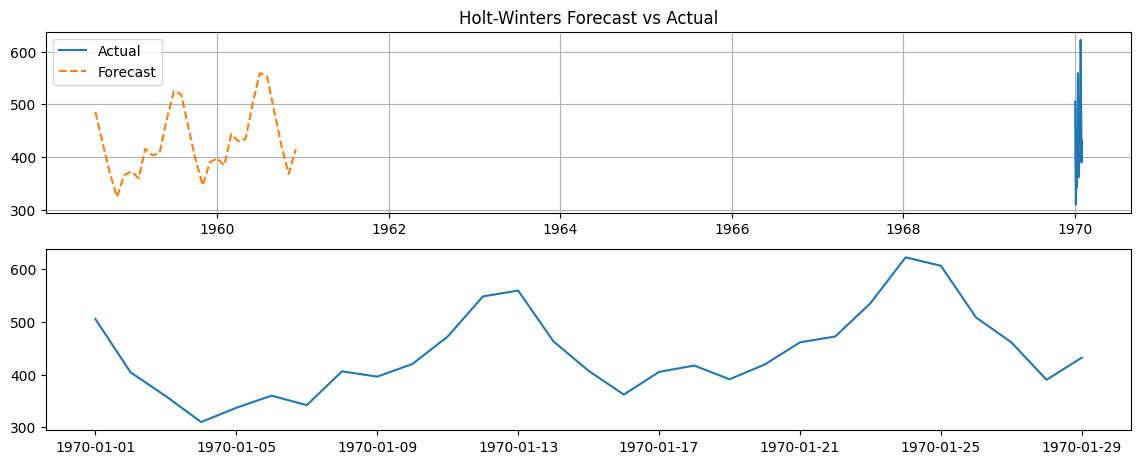

In [69]:
plt.figure(figsize=(14, 8))
for i, model in enumerate(top_models, 1):
    plt.subplot(len(top_models), 1, i)
    plt.plot(test.values, label='Actual')
    plt.plot(models[model], label='Forecast', linestyle='--')
    plt.title(f"{model} Forecast vs Actual")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

7. Metric Correlation Plot

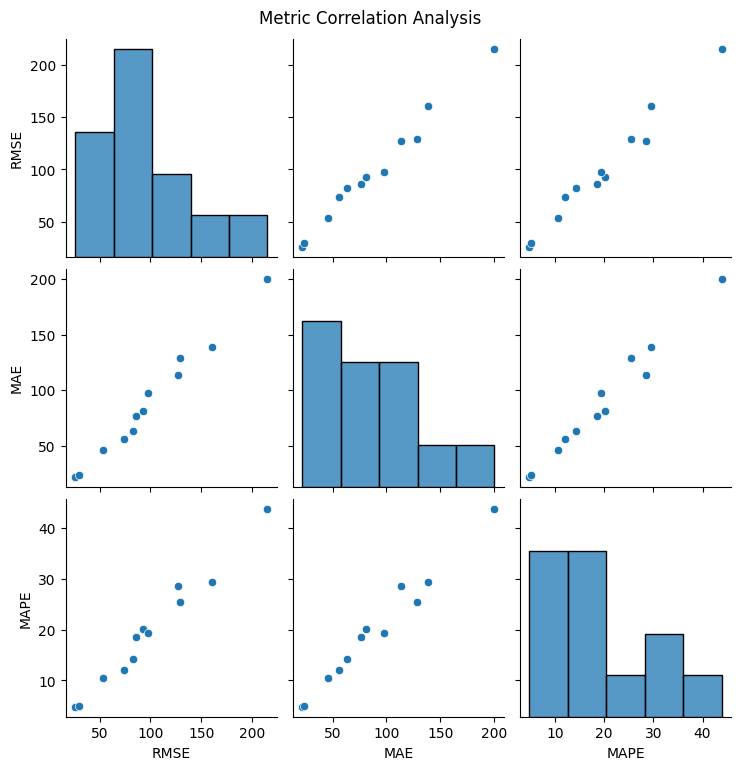

In [70]:
sns.pairplot(results_df[['RMSE', 'MAE', 'MAPE']])
plt.suptitle("Metric Correlation Analysis", y=1.02)
plt.show()